# PROBLEMA DEL VIAJANTE (TSP)

En el problema del viajante (TSP, por sus siglas en inglés), un vendedor debe visitar un 
conjunto de ciudades una sola vez y regresar a la ciudad de origen. 
El objetivo es minimizar la distancia total recorrida.

Este problema se vuelve más complejo a medida que van aumentando el número de ciudades, 
ya que la cantidad de rutas posibles crece exponencialmente. Por eso, resolverlo con fuerza 
bruta (es decir, evaluando todas las combinaciones posibles) se vuelve bastante impráctico o 
incluso imposible en términos de tiempo y recursos computacionales.

Un algoritmo genético (GA) es una herramienta muy adecuada para este tipo de problema, ya 
que puede explorar una gran cantidad de rutas posibles y utilizar principios evolutivos para 
encontrar, de manera eficiente, una solución que sea buena (aunque no necesariamente 
perfecta u óptima)

## Implementación en Python

### Criterio de selección: Inversa de la distancia total

1º) Definimos una lista con los nombres de las ciudades (ciudades) y una matriz de distancias 
(matriz_distancias) que representa las distancias entre todas las ciudades. Implementamos una 
función llamada crear_poblacion_inicial( ) que genera rutas aleatorias (cromosomas), cada una 
representando un orden diferente para visitar las ciudades. Estas rutas se mezclan 
aleatoriamente para formar la población inicial que se usará en el algoritmo genético. 


In [100]:
import random

random.seed(123)

ciudades=['A','B','C','D','E','F']

matriz_distancias=[
    [0,29,20,21,50,31],
    [29,0,50,29,55,40],
    [20,50,0,15,14,25],
    [21,29,15,0,19,36],
    [50,55,14,19,0,27],
    [31,40,25,36,27,0]
]

# Crear población inicial con rutas aleatorias

def crear_poblacion_inicial(tamano_poblacion):
    """Genera una población inicial con dutas aleatorias."""
    poblacion=[]
    
    for _ in range(tamano_poblacion):
        ruta=list(range(len(ciudades))) #Ruta con indices de ciudades
        random.shuffle(ruta) #Mezclar el orden
        poblacion.append(ruta)
    
    return poblacion

#Ejemplo de uso
print(crear_poblacion_inicial(3))

[[3, 4, 1, 5, 2, 0], [4, 1, 2, 3, 5, 0], [5, 3, 4, 1, 0, 2]]


La función calcular_distancia( ) toma una ruta (una lista de índices de ciudades) y suma las 
distancias entre cada ciudad consecutiva, después del último salto, agrega la distancia de 
regreso a la ciudad de inicio, cerrando el circuito y devuelve la distancia total recorrida por 
esa ruta

In [101]:
def calcular_distancia(ruta):
    """Calculamos la distancia total de una ruta usando la matriz de distancias"""
    distancia=0
    for i in range(len(ruta)-1):   #hasta el antepenultimo
        ciudad_actual=ruta[i]
        ciudad_siguiente=ruta[i+1]
        distancia+=matriz_distancias[ciudad_actual][ciudad_siguiente]
        
    #Añadir el regreso al punto inicial
    distancia+=matriz_distancias[ruta[-1]][ruta[0]]
    return distancia

#Ejemplo de uso
print(calcular_distancia([3,4,2,5,0,1]))

147


Implementamos un cruce ordenado (Ordered Crossover), seleccionamos aleatoriamente un 
segmento del primer padre y lo copia al hijo, luego rellenamos el resto con genes del 
segundo padre sin repetir ciudades. El resultado es una nueva ruta que mezcla información de 
ambos padres de manera válida.

In [102]:
def cruce(padre1,padre2):
    """Cruce ordenado entre dos padres para generar un hijo"""
    hijo=[-1]*len(ciudades) #Hijo vacio, con valores -1
    inicio,fin=sorted(random.sample(range(len(ciudades)),2))
    
    #Copiar un segmento del padre1 al hijo
    hijo[inicio:fin]=padre1[inicio:fin]
    
    #Rellenar con los genes del padre2, respetando el orden y evitando duplicados
    pos_padre2=0
    for i in range(len(ciudades)):
        if hijo[i]==-1:
            while padre2[pos_padre2] in hijo:
                pos_padre2+=1
            
            hijo[i]=padre2[pos_padre2]
    
    return hijo

#Ejemplo de uso
print(cruce([3,4,2,5,0,1],[4,2,3,1,0,5]))

[4, 3, 2, 5, 1, 0]


Recorre cada ciudad en la ruta, en cada posición, con cierta probabilidad (tasa_mutacion), 
intercambia la ciudad con otra aleatoria lo que permite introducir variabilidad y evitar que el 
algoritmo quede atrapado en soluciones locales

In [103]:
def mutar(ruta,tasa_mutacion):
    """Intercambia ciudades en una ruta aleatoriamente,según la tasa de mutación"""
    for i in range(len(ciudades)):
        if random.random()<tasa_mutacion:
            intercambiar_con=random.randint(0,len(ruta)-1) #hasta el antepenultimo
            ruta[i],ruta[intercambiar_con]=ruta[intercambiar_con], ruta[i]
    
    return ruta

#Ejemplo de uso
print(mutar([4,3,2,5,0,1],0.5))

[0, 5, 2, 1, 4, 3]


Usamos la función calcular_distancia() para obtener la distancia total de cada ruta, creamos una lista de tuplas con la forma: 

    [(ruta_1,distancia_1),(ruta_2,distancia_2),...]

Luego ordenamos la población según su desempeño: menor distancia = mayor aptitud. 

In [104]:
def ordenar_poblacion(poblacion):
    """Ordena la población por distancia total(menor es mejor)."""
    resultados=[(ruta,calcular_distancia(ruta)) for ruta in poblacion]
    return sorted(resultados,key=lambda x:x[1])  #la mejor ruta dada la poblacion original

#Ejemplo de uso
print(ordenar_poblacion([
    [4,1,0,2,5,3],
    [3,4,2,5,0,1]
]))

[([3, 4, 2, 5, 0, 1], 147), ([4, 1, 0, 2, 5, 3], 184)]


Pasamos la población ya ordenada por desempeño (menor distancia primero), extrae las 
primeras n rutas, según el tamano_elite, y las selecciona como los mejores individuos que 
pasarán automáticamente a la siguiente generación. Este proceso simula la selección natural, 
donde solo los mejores sobreviven sin cambios

In [105]:
def seleccion(poblacion_ordenada,tamano_elite):
    """Selecciona las rutas élite para la siguiente etapa."""
    resultados=[poblacion_ordenada[i][0] for i in range(tamano_elite)]
    return resultados

#Ejemplo de uso
seleccion(
    [([3,4,2,5,0,1],147),([4,1,0,2,5,3],184)],1
)

[[3, 4, 2, 5, 0, 1]]

Aplica los tres pilares del algoritmo genético: selección, cruce, y mutación. 
Se selecciona un conjunto élite que se conserva sin cambios, luego se generan hijos nuevos a 
partir de ese grupo, usando recombinación y mutación. El resultado es una nueva generación 
más adaptada que la anterior. 

In [106]:
def evolucionar_poblacion_clasico(poblacion,tamano_elite,tasa_mutacion):
    """Evolucionamos la población mediante selección,cruce y mutación."""
    poblacion_ordenada=ordenar_poblacion(poblacion)
    seleccionados=seleccion(poblacion_ordenada,tamano_elite)
    
    hijos=[]
    for _ in range(len(poblacion)-tamano_elite):
        padre1=random.choice(seleccionados)
        padre2=random.choice(seleccionados)
        hijo=cruce(padre1,padre2)
        hijo_mutado=mutar(hijo,tasa_mutacion)
        hijos.append(hijo_mutado)
        
    nueva_generacion=seleccionados+hijos
    return nueva_generacion

#Ejemplo de uso
evolucionar_poblacion_clasico(
    [
        [4,1,3,5,0,2],
        [0,5,2,4,1,3],
        [0,1,4,5,3,2],
        [3,5,0,2,4,1],
        [4,1,0,3,5,2]
    ],
    2,
    0.01
)



[[0, 5, 2, 4, 1, 3],
 [4, 1, 0, 3, 5, 2],
 [0, 5, 2, 4, 1, 3],
 [1, 0, 2, 4, 3, 5],
 [4, 1, 0, 3, 5, 2]]

Este bloque simula una población de rutas que evoluciona generación tras generación, 
buscando la mejor forma de recorrer todas las ciudades con la menor distancia posible. 
Primero, se generan rutas aleatorias; luego, a lo largo de 50 generaciones, las mejores rutas se 
cruzan, mutan y se seleccionan, como si estuvieran compitiendo por sobrevivir. En cada paso, 
se guarda la distancia de la mejor solución encontrada. 

Mejor Ruta: D-->C-->E-->F-->A-->B
Distancia total 145


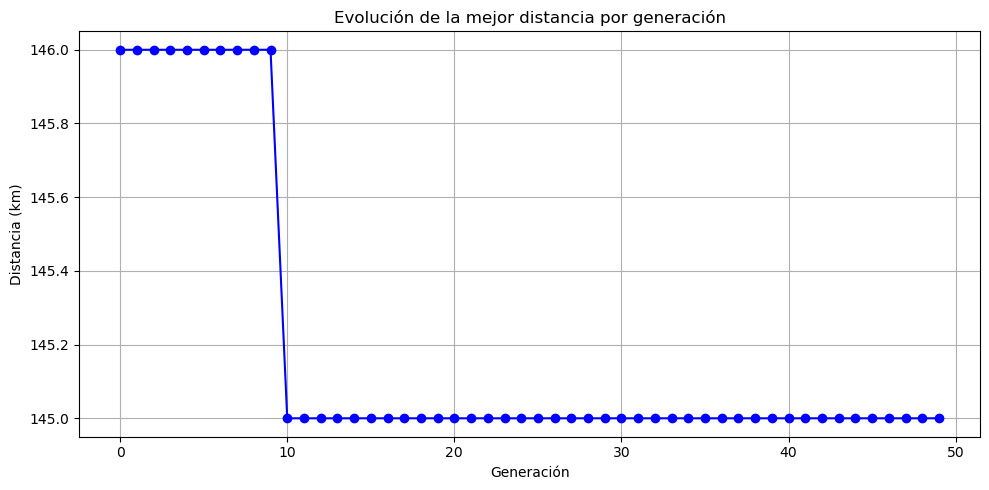

In [107]:
import matplotlib.pyplot as plt

tamano_poblacion=6
tamano_elite=3
tasa_mutacion=0.1
generaciones=50
historial_distancias_clasico=[]

#Crear poblacion inicial
poblacion=crear_poblacion_inicial(tamano_poblacion)  #una poblacion, 6 rutas

#Ejecutar evolucion por generaciones
for gen in range(generaciones):
    poblacion=evolucionar_poblacion_clasico(poblacion,tamano_elite,tasa_mutacion)
    mejor_ruta=ordenar_poblacion(poblacion)[0]
    historial_distancias_clasico.append(mejor_ruta[1])

#Mostrar la mejor ruta final
mejor_ruta=ordenar_poblacion(poblacion)[0][0]  
mejor_distancia=ordenar_poblacion(poblacion)[0][1]
nombres_ciudades=[ciudades[i] for i in mejor_ruta]

#Imprimir resultados
print("Mejor Ruta:","-->".join(nombres_ciudades))
print(f"Distancia total {mejor_distancia}")

#Graficar evolución de la distancia

plt.figure(figsize=(10,5))
plt.plot(historial_distancias_clasico,marker='o', color='blue')
plt.title("Evolución de la mejor distancia por generación")
plt.xlabel("Generación")
plt.ylabel("Distancia (km)")
plt.grid(True)
plt.tight_layout()
plt.show()




In [108]:
historial_distancias_clasico[:6]

[146, 146, 146, 146, 146, 146]

Al final, el algoritmo imprime la mejor ruta en lenguaje humano (A → B → C...) y muestra una 
gráfica que revela visualmente cómo esa solución fue mejorando con el tiempo, hasta 
estabilizarse.

¿Qué podemos observar?

- Al inicio (generaciones de 0 a 10) la distancia comienza en 146km.
- A partir de la generaciones 11, el algoritmo mejora y alcanza una distancia de 145km durante el resto de generaciones.

Esto indica que el algoritmo encontró una solución sólida y no mejoró más después de 
cierto punto, lo cual es bastante común en algoritmos evolutivos: encuentran un óptimo local 
(o cercano al global) y se estabilizan.

** Idea de proyecto **

Hacer este modelo pero en vez de tener como criterio de seleccion la aptitud = la inversa de la distancia total, tenemos como criterio de seleccion el mejor r cuadrado ajsutado de una regresion. Y comparamos las soluciones de ambos criterios a ver si coinciden.

## Implementación en Python

### Criterio: distancia mínima que predice el modelo lineal simple

Para incorporar la regresión lineal en este algoritmo genético, con el objetivo de usar las distancias predichas como criterio de selección, debemos realizar algunas modificaciones clave. La regresión lineal se utilizará para predecir las distancias en función de las rutas generadas por el algoritmo genético. Luego, estas predicciones de distancia serán utilizadas para ordenar la población y seleccionar los individuos con las distancias más cortas, como si fueran las "mejores" rutas.

- Modelo de regresión lineal: Utilizamos un modelo de regresión lineal para predecir las distancias. Las rutas de las poblaciones son las variables predictoras y las distancias reales entre ciudades son las variables a predecir.

- Predicción de distancias: Después de crear el modelo de regresión, predicimos las distancias para las rutas de cada generación.

- Criterio de selección: Las distancias predichas se usarán como criterio de selección, donde las rutas con menor distancia predicha serán seleccionadas.

In [109]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [110]:
random.seed(123)

ciudades = ['A', 'B', 'C', 'D', 'E', 'F']

matriz_distancias = [
    [0, 29, 20, 21, 50, 31],
    [29, 0, 50, 29, 55, 40],
    [20, 50, 0, 15, 14, 25],
    [21, 29, 15, 0, 19, 36],
    [50, 55, 14, 19, 0, 27],
    [31, 40, 25, 36, 27, 0]
]

In [111]:
def crear_poblacion_inicial(tamano_poblacion):
    poblacion = []
    for _ in range(tamano_poblacion):
        ruta = list(range(len(ciudades)))  # Ruta con indices de ciudades
        random.shuffle(ruta)  # Mezclar el orden
        poblacion.append(ruta)
    return poblacion

In [112]:
def calcular_distancia(ruta):
    """Calculamos la distancia total de una ruta usando la matriz de distancias"""
    distancia = 0
    for i in range(len(ruta)-1):   # hasta el antepenúltimo
        ciudad_actual = ruta[i]
        ciudad_siguiente = ruta[i+1]
        distancia += matriz_distancias[ciudad_actual][ciudad_siguiente]
        
    # Añadir el regreso al punto inicial
    distancia += matriz_distancias[ruta[-1]][ruta[0]]
    return distancia

In [113]:
def cruce(padre1, padre2):
    """Cruce ordenado entre dos padres para generar un hijo"""
    hijo = [-1] * len(ciudades)  # Hijo vacío, con valores -1
    inicio, fin = sorted(random.sample(range(len(ciudades)), 2))
    
    # Copiar un segmento del padre1 al hijo
    hijo[inicio:fin] = padre1[inicio:fin]
    
    # Rellenar con los genes del padre2, respetando el orden y evitando duplicados
    pos_padre2 = 0
    for i in range(len(ciudades)):
        if hijo[i] == -1:
            while padre2[pos_padre2] in hijo:
                pos_padre2 += 1
            hijo[i] = padre2[pos_padre2]
    
    return hijo

In [114]:
def mutar(ruta, tasa_mutacion):
    """Intercambia ciudades en una ruta aleatoriamente, según la tasa de mutación"""
    for i in range(len(ciudades)):
        if random.random() < tasa_mutacion:
            intercambiar_con = random.randint(0, len(ruta)-1)  # hasta el antepenúltimo
            ruta[i], ruta[intercambiar_con] = ruta[intercambiar_con], ruta[i]
    return ruta

In [115]:
def ordenar_poblacion(poblacion, modelo_regresion=None):
    """Ordena la población por las distancias predichas (menor es mejor)."""
    if modelo_regresion is None:
        # Si no hay modelo de regresión, usar la distancia real
        resultados = [(ruta, calcular_distancia(ruta)) for ruta in poblacion]
    else:
        # Si hay modelo de regresión, predecir las distancias
        rutas = np.array([ruta for ruta in poblacion])
        distancias_predichas = modelo_regresion.predict(rutas)
        resultados = list(zip(poblacion, distancias_predichas))
    
    # Devuelve las rutas ordenadas por las distancias predichas
    return sorted(resultados, key=lambda x: x[1])  # la mejor ruta dada la población original


In [116]:
def seleccion(poblacion_ordenada, tamano_elite):
    """Selecciona las rutas élite para la siguiente etapa."""
    resultados = [poblacion_ordenada[i][0] for i in range(tamano_elite)]
    return resultados

In [117]:
def evolucionar_poblacion(poblacion, tamano_elite, tasa_mutacion, modelo_regresion=None):
    """Evolucionamos la población mediante selección, cruce y mutación."""
    poblacion_ordenada = ordenar_poblacion(poblacion, modelo_regresion)
    seleccionados = seleccion(poblacion_ordenada, tamano_elite)
    
    hijos = []
    for _ in range(len(poblacion) - tamano_elite):
        padre1 = random.choice(seleccionados)
        padre2 = random.choice(seleccionados)
        hijo = cruce(padre1, padre2)
        hijo_mutado = mutar(hijo, tasa_mutacion)
        hijos.append(hijo_mutado)
        
    nueva_generacion = seleccionados + hijos
    return nueva_generacion

In [118]:
# Generar datos para la regresión lineal
def generar_datos_regresion(poblacion):
    """Genera datos para entrenar un modelo de regresión lineal sobre las rutas."""
    X = []
    y = []
    for ruta in poblacion:
        X.append(ruta)  # Usamos la ruta como las variables predictoras (características)
        y.append(calcular_distancia(ruta))  # La distancia real es el valor a predecir
    return np.array(X), np.array(y)

In [119]:
# Entrenar el modelo de regresión lineal
def entrenar_modelo(poblacion):
    X, y = generar_datos_regresion(poblacion)
    modelo = LinearRegression()
    modelo.fit(X, y)
    return modelo

In [120]:
# Parametros del algoritmo
tamano_poblacion = 6
tamano_elite = 3
tasa_mutacion = 0.1
generaciones = 50
historial_distancias_predichas_regresion = []  # Lista para almacenar las distancias predichas

# Crear población inicial
poblacion = crear_poblacion_inicial(tamano_poblacion)

In [121]:
# Entrenar el modelo de regresión
modelo_regresion = entrenar_modelo(poblacion)

# Ejecutar evolución por generaciones
for gen in range(generaciones):
    poblacion = evolucionar_poblacion(poblacion, tamano_elite, tasa_mutacion, modelo_regresion)
    poblacion_ordenada = ordenar_poblacion(poblacion, modelo_regresion)  # Obtener la población ordenada
    mejor_ruta = poblacion_ordenada[0]  # Mejor ruta de la generación
    historial_distancias_predichas_regresion.append(mejor_ruta[1])  # Guardar la distancia predicha

# Mostrar la mejor ruta final
mejor_ruta = ordenar_poblacion(poblacion, modelo_regresion)[0][0]
mejor_distancia = ordenar_poblacion(poblacion, modelo_regresion)[0][1]
nombres_ciudades = [ciudades[i] for i in mejor_ruta]

# Imprimir resultados
print("Mejor Ruta:", "-->".join(nombres_ciudades))
print(f"Distancia total predicha: {mejor_distancia}")

Mejor Ruta: C-->F-->B-->E-->A-->D
Distancia total predicha: 152.04761904761904


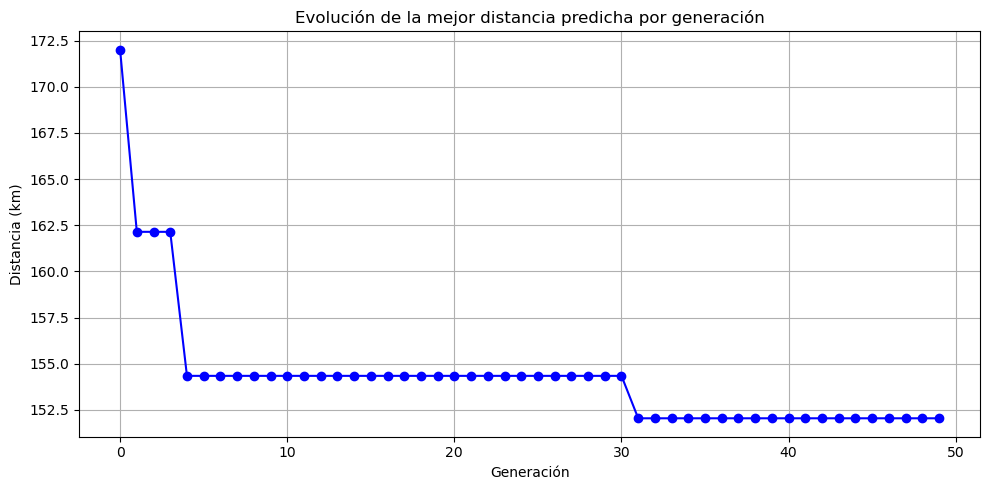

In [122]:
# Graficar evolución de la distancia predicha
plt.figure(figsize=(10, 5))
plt.plot(historial_distancias_predichas, marker='o', color='blue')
plt.title("Evolución de la mejor distancia predicha por generación")
plt.xlabel("Generación")
plt.ylabel("Distancia (km)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
historial_distancias_predichas_regresion[:6]

[172.0,
 162.14285714285717,
 162.14285714285717,
 162.14285714285717,
 154.3452380952381,
 154.3452380952381]

## Comparación del modelo clásico VS modelo regresión lineal

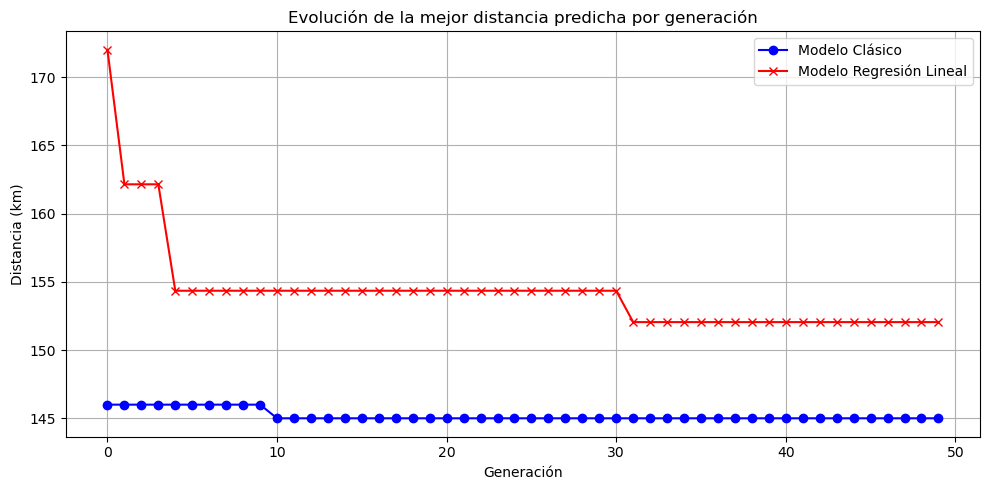

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(historial_distancias_clasico, marker='o', color='blue',label="Modelo Clásico")
plt.plot(historial_distancias_predichas_regresion,marker='x',color='r',label="Modelo Regresión Lineal")
plt.title("Evolución de la mejor distancia predicha por generación")
plt.xlabel("Generación")
plt.ylabel("Distancia (km)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
# Análisis de la dispersión

# Desviación estándar para el modelo clásico y el modelo de regresión
std_clasico = np.std(historial_distancias_clasico)
std_regresion = np.std(historial_distancias_predichas_regresion)

print(f"Desviación estándar del modelo clásico: {std_clasico}")
print(f"Desviación estándar del modelo de regresión: {std_regresion}")


Desviación estándar del modelo clásico: 0.4
Desviación estándar del modelo de regresión: 3.447507142685313


In [126]:
# Porcentaje de coincidencia
distancia_tolerancia=10 #10km de margen

coincidencias = np.sum(np.isclose(historial_distancias_clasico, historial_distancias_predichas_regresion, atol=distancia_tolerancia))  
porcentaje_coincidencia = (coincidencias / len(historial_distancias_clasico)) * 100

print(f"Porcentaje de coincidencia: {porcentaje_coincidencia}%")


Porcentaje de coincidencia: 92.0%


El modelo clásico se estabiliza mucho antes y consigue encontrar una ruta cuya distancia es 145km.
El modelo de regresión lineal tarda en estabilizarse algo más y consigue encontrar una ruta cuya distancia es 152km. 
La diferencia de optimizacion de la distancia es de 7km, es prácticamente desdeñable y ambos modelos nos permiten encontrar las rutas mas cortas, pero de optar unicamente por una, es preferible el modelo clásico.